## Modelo Random Forest

In [1]:
## Se importan las librerias requeridas para aplicar el modelo
# Manipulación datos
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
warnings.filterwarnings('once')

import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\Felipe\anaconda3\envs\Financiero\lib\site-packages\pandas_datareader\compat\__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


### Carga de los Datos

Se procede a cargar la información de Yahoo Finance del Activo de META

In [28]:
## Se definen la fecha de inicio y fin de acuerdo con lo establecido en la Evaluación del Modulo Parte 2
start = '2016-05-01'
end = '2018-01-28'

In [29]:
#Se bajan los datos a través de Yahoo Finance
data = pdr.get_data_yahoo("META", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [30]:
#Se cambia el nombre de la columna del tipo de precio a "y", para facilidad posterior.
dt= pandas.DataFrame(data)
df= dt.rename(columns={'Close': 'y'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 439 entries, 2016-05-02 to 2018-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB


In [31]:
df.head()

,y
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


### Preprocesamiento de los datos

Con base en lo aprendido durante los tutoriales de la semana 4 se procede a realizar el proceso de preprocesamiento de la información para que pueda ser aplicada a Random Forest

In [32]:
## Se ajusta el formato de los datos
dataindex= pd.to_datetime(df.index)
dataindex

DatetimeIndex(['2016-05-02', '2016-05-03', '2016-05-04', '2016-05-05',
               '2016-05-06', '2016-05-09', '2016-05-10', '2016-05-11',
               '2016-05-12', '2016-05-13',
               ...
               '2018-01-12', '2018-01-16', '2018-01-17', '2018-01-18',
               '2018-01-19', '2018-01-22', '2018-01-23', '2018-01-24',
               '2018-01-25', '2018-01-26'],
              dtype='datetime64[ns]', name='Date', length=439, freq=None)

In [33]:
# Se da formato de fecha con periodiciadad diaria a la serie.
df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')  
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  
df = df.set_index('Date')
df = df.asfreq('B')
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2016-05-02 to 2018-01-26
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [34]:
## Se llena cualquier valor faltante con el valor anterior
## Imputamos algún valor faltante con el valor anterior.
df.fillna(method='bfill', inplace=True)

In [35]:
## Se verifica que no existan celdas vacias
# Podemos verificar si valores faltantes.
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [36]:
print(len(df))

455


### Partición de los datos

Se proceden a divir los datos en entrenamiento y prueba

In [37]:
# Split data into train-test
# ==============================================================================
steps = int(len(df)*0.05)
data_train = df[:-steps]
data_test  = df[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

Train dates : 2016-05-02 00:00:00 --- 2017-12-27 00:00:00  (n=433)
Test dates  : 2017-12-28 00:00:00 --- 2018-01-26 00:00:00  (n=22)


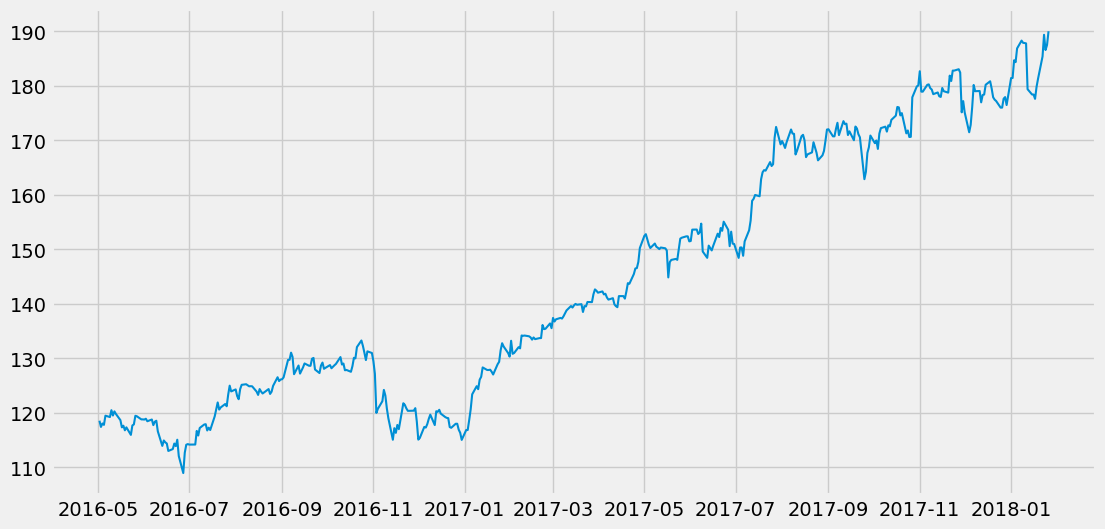

In [38]:
## Se grafican los datos financieros
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df)

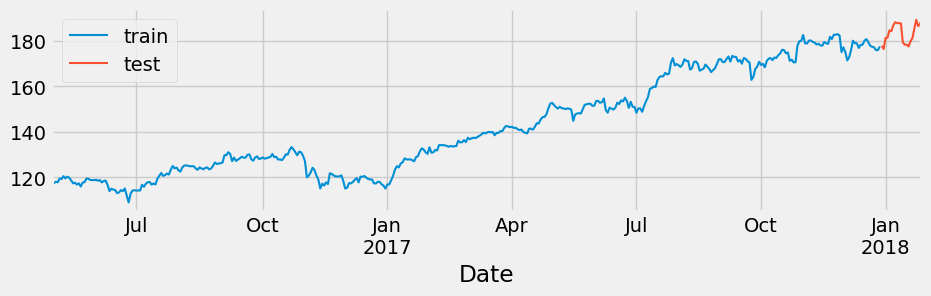

In [39]:
## Gráfica de los datos de entrenamiento y prueba
fig, ax = plt.subplots(figsize=(10, 2.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

### Modelamiento

Se procede a realizar el proceso de regresión con el modelo de Random Forest

In [40]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 15
                )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-05-02 00:00:00'), Timestamp('2017-12-27 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: B 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-12 00:39:24 
Last fit date: 2024-05-12 00:39:24 
Skforecast 

In [41]:
## Se calcula la predicción
steps = steps = int(len(df)*0.05)
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2017-12-28    178.341898
2017-12-29    179.147699
2018-01-01    179.512100
2018-01-02    179.552199
2018-01-03    179.411599
Freq: B, Name: pred, dtype: float64

In [42]:
### Se determina rápidamente el error del pronostico
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 35.01610306008772
Test error (rmse): 5.917440583570546


### Ajuste de Hiperparametros

Calculado ya el modelo se procede a realizar el calculo de hiperparametros con grid search para elegir los mejores valores que estos pueden tomar

In [43]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 
             )

# Lags used as predictors
lags_grid = [5, 10, 15, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 19.196979987164895



In [44]:
## Se visualizan los resultados
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",19.196980,5,100
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 1000}",19.353609,5,1000
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",19.512671,10,100
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",19.538992,5,100
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 1000}",19.657158,10,1000
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",19.677490,5,500
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",19.721096,10,500
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 1000}",19.775545,5,1000
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",19.781965,5,500
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",20.069863,10,100


### Modelo Óptimo

Con base en los resultados del grid search se procede a correr el modelo óptimo

In [67]:
## Modelo Optimo

regressor = RandomForestRegressor(max_depth= 5, n_estimators=100 , random_state=123)


forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
                )

forecaster.fit(y=df['y'])
f = forecaster.fit(y=df['y'])

In [56]:
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.337982
1,lag_2,0.148783
2,lag_3,0.292970
3,lag_4,0.100297
4,lag_5,0.092256
5,lag_6,0.006035
6,lag_7,0.001957
7,lag_8,0.009627
8,lag_9,0.001617
9,lag_10,0.008475


In [57]:
## Se calcula la predicción
steps = steps = int(len(df)*0.05)
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2017-12-28    177.576686
2017-12-29    177.665954
2018-01-01    178.474349
2018-01-02    179.282816
2018-01-03    179.340032
Freq: B, Name: pred, dtype: float64

In [58]:
len(predictions)

22

In [59]:
### Se determina rápidamente el error del pronostico
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Test error (mse): 36.65913729395208
Test error (rmse): 6.054678958784857


### Pronóstico hacia adelante

Con base en lo aprendido en el tutorias se procede a realizar el pronostico hacia adelante de 10 días

In [68]:
# Se elige ventana de 10 días de acuerdo con lo solicitado.
steps = 10
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2018-01-29    186.670212
2018-01-30    185.924226
2018-01-31    184.505939
2018-02-01    183.412205
2018-02-02    181.215919
Freq: B, Name: pred, dtype: float64

In [69]:
fin = data_test.index.max() 
fin

Timestamp('2018-01-26 00:00:00', freq='B')

In [70]:
## Se generan las fechas de los pronósticos mediante la función de pandas date_range:
fin = data_test.index.max()   #Partimos de la fecha máxima de la sección de prueba, hacia adelante.
fwd_dates = pd.date_range(fin, periods=10, freq='D').tolist()
fwd_dates

[Timestamp('2018-01-26 00:00:00', freq='D'),
 Timestamp('2018-01-27 00:00:00', freq='D'),
 Timestamp('2018-01-28 00:00:00', freq='D'),
 Timestamp('2018-01-29 00:00:00', freq='D'),
 Timestamp('2018-01-30 00:00:00', freq='D'),
 Timestamp('2018-01-31 00:00:00', freq='D'),
 Timestamp('2018-02-01 00:00:00', freq='D'),
 Timestamp('2018-02-02 00:00:00', freq='D'),
 Timestamp('2018-02-03 00:00:00', freq='D'),
 Timestamp('2018-02-04 00:00:00', freq='D')]

In [71]:
## Se gráfica la visualización del pronostico

## Graficamos la serie anterior, aunando el valor del pronóstico.

trace3 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'Test'
)

trace4 = go.Scatter(
    x = fwd_dates,
    y = predictions,
    mode = 'lines',
    name = 'Pronóstico Futuro Random Forest'
)

trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Train'
    )

layout = go.Layout(
    title = "META",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace3, trace4], layout=layout)
fig.show()